# Monte Carlo Methods

## Why Monte Carlo?

Draw random samples that follow a predefined probability distribution to:

* find (multiple) maxima of the probability distribution
* calculate integrals (i.e., expectation values) of functions, weighted by the probability distribution
* characterize the probability distribution, find correlations between parameters, etc.

## Drawing from a one-dimensional PDF

### Drawing uniformly distributed (pseudo-)random numbers

Computers are deterministic. However, we can generate so-called pseudo-random numbers.

Idea: Use some formula whose outcome depends sensitively on the input; iterate.

Note: Need starting point for the iteration (random number seed), but that makes the result reproducible.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rng(m=2**32, a=1103515245, b=12345):
    """This function updates the (pseudo-)random number to a new one."""
    rng.current = (a*rng.current + b) % m
    return 1.*rng.current/m

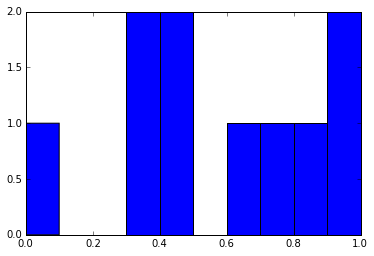

In [3]:
rng.current = 101 #setting the random number seed
random_numbers = np.array([rng() for i in range(10)]) #Draw a few random numbers
plt.hist(random_numbers,range=(0.,1.),bins=10) #plot them
plt.show()

In numpy, this is already implemented as np.random.random() (or np.random.uniform())

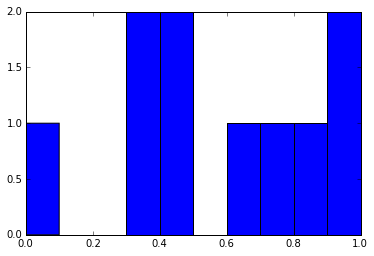

In [4]:
np.random.seed(101)
random_numbers2 = np.random.random(10)
plt.hist(random_numbers,range=(0.,1.),bins=10)
plt.show()

### Drawing non-uniformly distributed random values

We can draw random numbers uniformly between 0 and 1 and then transform them to follow any one-dimensional distribution. In this example, we will use a simple Gaussian distribution.

* Calculate cumulative probability distribution (CDF): $\mathrm{CDF}(x) = \int_{-\infty}^x \mathrm{d}x' P(x)$
* invert that function to get the inverse cumulative probability distribution (iCDF)
* draw random values $y$ between 0 and 1
* evaluate $\mathrm{iCDF}(y)$ to find values of $x$ following the distribution $P(x)$

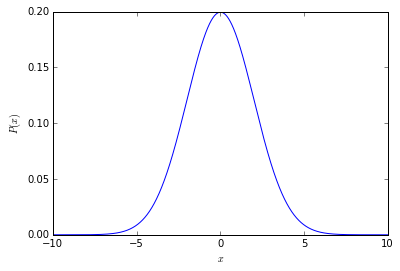

In [5]:
xmin = -10. #set up an array of x-values
xmax = 10.
dx = 0.01
x = np.arange(xmin,xmax + dx,dx)

sigma = 2. #set the standard deviation of the Gaussian
P = 1./(2.*np.pi*sigma**2)**0.5*np.exp(-x**2/(2.*sigma**2)) #Gaussian PDF

plt.plot(x,P)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(x)$')
plt.show()

In [ ]:
from scipy.special import erf
CDF = 0.5*(1. + np.sign(x)*erf(np.abs(x/2**0.5/sigma))) #Gaussian CDF

plt.plot(x,CDF)
plt.xlabel(r'$x$')
plt.ylabel(r'CDF$(x)$')
plt.show()

In [ ]:
from scipy.special import erfinv
y = np.arange(0.,1.+0.01,0.01)

def iCDF(y,sigma): #inverse CDF
    return 2**0.5*sigma*erfinv(2.*y - 1.)

iCDF_arr = iCDF(y,sigma)
plt.plot(y,iCDF_arr)
plt.xlabel(r'$y$')
plt.ylabel(r'$x$')
plt.show()

In [ ]:
n = 200 #Number of random samples to draw

yvals = np.random.uniform(0.,1.,n) #Draw uniformly distributed values for y
xvals = iCDF(yvals,sigma) #Convert these values to values of x

plt.hist(xvals,range=(-10,10),bins=20,normed=True) #plot a histogram for x
plt.xlabel(r'$x$')
plt.ylabel(r'sample distribution')
plt.plot(x,P,label='exact PDF')
plt.legend()
plt.show()

With these random samples, we can estimate some expectation values, for example the first few moments of the Gaussian distribution:

In [ ]:
print 'zeroth order:', 1., (xvals**0).sum()/n
print 'first order:', 0., (xvals**1).sum()/n
print 'second order:', sigma**2, (xvals**2).sum()/n
print 'third order:', 0., (xvals**3).sum()/n
print 'fourth order:', 3.*sigma**4, (xvals**4).sum()/n
print 'cos(x):', np.exp(-1./2.*sigma**2), np.cos(xvals).sum()/n

In numpy, drawing Gaussian random numbers is also provided as a predefined function (np.random.normal()):

In [ ]:
xvals2 = np.random.normal(0.,sigma,n)

plt.hist(xvals2,range=(-10,10),bins=20,normed=True) #plot a histogram for x
plt.xlabel(r'$x$')
plt.ylabel(r'sample distribution')
plt.plot(x,P,label='exact PDF')
plt.legend()
plt.show()

## Drawing from N-dimensional PDFs -- rejection sampling

In more than one dimension, there is no well-defined cumulative distribution function. Thus, we have to come up with a new idea:

* Sample (some region of) N-dimensional space following a simple PDF $Q(x)$ (we will use a uniform distribution.
* Add an acceptance-rejection step that accepts the sample $x$ with probability $P(x)/(c\ Q(x))$.
* Choose $c$ such that $P(x) < c\ Q(x)$ for all $x$ (but ideally not too large).

We will use a two-dimensional Gaussian in this example.

In [ ]:
#Set up a two-dimensional grid for plotting purposes:
xvals = np.arange(-10,10.01,0.01)
yvals = np.arange(-10,10.01,0.01)
gridx, gridy = np.meshgrid(xvals,yvals)

#Define the two-dimensional Gaussian:
cov_xx = 6.
cov_yy = 1.5
cov_xy = 1.0
cov = np.array([[cov_xx,cov_xy],[cov_xy,cov_yy]])
invcov = np.linalg.inv(cov)

def twoDGauss(x,y,cov,invcov):
    det = np.linalg.det(cov)
    norm = 1./(2.*np.pi)/det**0.5
    return norm*np.exp(-0.5*(x*(invcov[0,0]*x + invcov[0,1]*y) + y*(invcov[1,0]*x + invcov[1,1]*y)))

#Evaluate the Gaussian at all grid points and plot it:
G = twoDGauss(gridx,gridy,cov,invcov)

plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.show()

In [ ]:
#Define drawing step:
def draw_sample():
    return np.random.uniform(-10,10,2) #two-dimensional uniform distribution

#Define the acceptance-rejection step:
c = 40.
D = 2 #dimension of the parameter space

def AcceptReject(c,D,P,*Pargs):
    """This function returns `True' if the sample is accepted and `False' if not. We use a
    variable-length argument list `*Pargs' to be able to use any probability function `P' that we
    might come up with"""
    Pval = P(*Pargs)
    proposalval = 1./20**D #The proposal density is 1/20*1/20
    prob = Pval/(c*proposalval)
    return np.random.choice([True,False],p=[prob,1.-prob])

In [ ]:
#Draw some samples:
N = 10000 #number of samples to draw
count = 0 #count the accepted samples
samples = [] #store the accepted samples

for i in range(N):
    samp = draw_sample()
    acc = AcceptReject(c,D,twoDGauss,samp[0],samp[1],cov,invcov)
    if acc:
        count += 1
        samples.append(samp)
samples = np.array(samples)

plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(samples[:,0],samples[:,1],'.',color='red')
plt.show()
print 'acceptance ratio:', 1.*count/N

In [ ]:
#Let's calculate some moments of the PDF:
samples = np.array(samples)
print 'mean x:', np.mean(samples[:,0])
print 'mean y:', np.mean(samples[:,1])
print 'variance in x-direction:', np.mean(samples[:,0]**2)
print 'variance in y-direction:', np.mean(samples[:,1]**2)
print 'covariance of x and y:', np.mean(samples[:,0]*samples[:,1])

Now let's see what happens if we go to higher dimensions. For simplicity, we use a symmetric Gaussian without correlations.

In [ ]:
#Define the D-dimensional Gaussian:
sigma = 2.
def DdimGauss(xvec,sigma,D):
    det = sigma**(2*D)
    norm = 1./(2.*np.pi)**(D/2.)/det**0.5
    return norm*np.exp(-0.5*np.dot(xvec,xvec/sigma**2))

#Define the drawing step:
def draw_sample_Ddim(D):
    return np.random.uniform(-10,10,D) #D-dimensional uniform distribution

In [ ]:
#Draw some samples:
N = 10000 #number of samples to draw
count = 0 #count the accepted samples
samples = [] #store the accepted samples
D = 1

#Here we are cheating a bit: Since we know what the maximum of the D-dimensional PDF is, we can
#calculate the optimal value of c to use:
c = DdimGauss(np.zeros(D),sigma,D)*20.**D
print 'c =', c

for i in range(N):
    samp = draw_sample_Ddim(D)
    acc = AcceptReject(c,D,DdimGauss,samp,sigma,D)
    if acc:
        count += 1
        samples.append(samp)

print 'acceptance ratio:', 1.*count/N

This problem is known as "the curse of dimensionality"

Note: For the special case of Gaussian probability distributions, there is actually a more direct way of drawing random samples (ask me later if you're interested).

## Markov Chain Monte Carlo -- Metropolis Hastings

Markov Chain: Draw random samples in an ordered chain:

* "Markov" property: Each sample depends on the sample before, but not on any other samples
* Pro: Curse of dimensionality less severe
* Con: Successive samples are correlated -> need to discard many of them to obtain a set of independent samples

Specific example: Metropolis-Hastings

* Select a "proposal density" $Q(x'|x)$ to draw a new sample $x'$ given a previous sample $x$
* If $P(x') \geq P(x)$, accept the new sample
* If $P(x') < P(x)$, accept the new sample with probability $P(x')/P(x)$
* If a sample is rejected, the chain stays at the same position (i.e., the old sample is repeated).
* Note that the normalization of $P$ doesn't matter.

Let's work again with our two-dimensional Gaussian.

In [ ]:
#Set up a two-dimensional grid for plotting purposes:
xvals = np.arange(-10,10.01,0.01)
yvals = np.arange(-10,10.01,0.01)
gridx, gridy = np.meshgrid(xvals,yvals)

#Define the two-dimensional Gaussian:
cov_xx = 6.
cov_yy = 1.5
cov_xy = 1.0
cov = np.array([[cov_xx,cov_xy],[cov_xy,cov_yy]])
invcov = np.linalg.inv(cov)
def twoDGauss(samp,cov,invcov):
    x = samp[0]
    y = samp[1]
    det = np.linalg.det(cov)
    norm = 1./(2.*np.pi)/det**0.5
    return norm*np.exp(-0.5*(x*(invcov[0,0]*x + invcov[0,1]*y) + y*(invcov[1,0]*x + invcov[1,1]*y)))

#Evaluate the Gaussian at all grid points and plot it:
G = twoDGauss([gridx,gridy],cov,invcov)

plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.show()

In [ ]:
#Define the proposal step (we are using a symmetric Gaussian proposal density):
def proposal(oldsamp,sigmaprop,D):
    newsamp = oldsamp + np.random.normal(0.,sigmaprop,D)
    return newsamp

#Define the acceptance-rejection step (return the new sample and a boolean that tells us whether
#or not the new sample was accepted):
def accept(newsamp,oldsamp,P,*Pargs):
    """This function returns a boolean variable that tells us whether or not the proposed sample was
    accepted and the new sample itself."""
    newprob = P(newsamp,*Pargs)
    oldprob = P(oldsamp,*Pargs)
    if newprob >= oldprob:
        acc = True
        return acc, newsamp
    else:
        prob = newprob/oldprob
        acc = np.random.choice([True,False],p=[prob,1.-prob])
        return acc, acc*newsamp + (1. - acc)*oldsamp #Note that this is either newsamp or oldsamp

#Define function that runs an entire chain:
def run_chain(steps,sigmaprop,D,P,*Pargs):
    oldsamp = np.random.uniform(-10,10,D) #Draw a random starting point
    count = 0 #Count the number of accepted samples
    samples = [oldsamp] #Store all samples
    for i in range(steps):
        newsamp = proposal(oldsamp,sigmaprop,D) #Propose a new sample
        acc, newsamp = accept(newsamp,oldsamp,P,*Pargs) #decide whether or not to accept it
        samples.append(newsamp) #Add the sample to the list of samples
        if acc:
            count += 1
        oldsamp = newsamp #Move to the new sample
    ar = 1.*count/steps #compute the acceptance ratio
    return np.array(samples), ar

In [ ]:
#Run a chain:
Nsteps = 200 #number of steps to run the chain for
sigmaprop = 1. #width of the proposal distribution
D = 2 #dimension of the parameter space
samples, ar = run_chain(Nsteps,sigmaprop,D,twoDGauss,cov,invcov) #run the chain
print 'acceptance ratio:', ar

#Plot the chain on top of the 2D-density:
plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(samples[:,0],samples[:,1],'-',color='red')
plt.show()

In [ ]:
#plot the x-values of the samples:
plt.plot(samples[:,0])
plt.xlabel(r'sample number')
plt.ylabel(r'$x$')
plt.show()

In [ ]:
#use the plot to determine how many samples to throw out as "burn-in":
burnin = 50
non_burnin_samples = samples[burnin:]

In [ ]:
#now plot the auto-correlation of the remaining samples:
num = np.convolve(non_burnin_samples[:,0],non_burnin_samples[:,0][::-1],mode='same')
den = np.convolve(np.ones(len(non_burnin_samples)),np.ones(len(non_burnin_samples)),mode='same')
autocorr = num/den
plt.plot(np.arange(-non_burnin_samples.shape[0]//2,non_burnin_samples.shape[0]//2,1),autocorr)
plt.xlabel(r'difference in sample number')
plt.ylabel(r'correlation')
plt.show()

In [ ]:
#use the plot to determine the correlation length between samples
corrlength = 25
independentsamples = non_burnin_samples[::corrlength]
print independentsamples.shape
print 'effective acceptance ratio:', 1.*independentsamples.shape[0]/Nsteps

In [ ]:
#Plot only the independent samples:
plt.imshow(G,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(independentsamples[:,0],independentsamples[:,1],'.',color='red')
plt.show()

Let's try a multimodal distribution.

In [ ]:
#Define a multimodal distribution (remember that the normalization doesn't matter):
def multimodal(samp,cov,invcov):
    x = samp[0]
    y = samp[1]
    return twoDGauss(samp,cov,invcov) + 0.1*np.exp(-0.5*((x-5.)**2 + (y-5)**2))

#Plot it:
mm = multimodal([gridx,gridy],cov,invcov)
plt.imshow(mm,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.show()

In [ ]:
#Run a chain:
Nsteps = 200
sigmaprop = 1.0
D = 2
samples, ar = run_chain(Nsteps,sigmaprop,D,multimodal,cov,invcov)
print 'acceptance ratio:', ar

#Plot the chain on top of the 2D-density:
plt.imshow(mm,cmap=plt.cm.Blues,extent=[xvals.min(),xvals.max(),yvals.max(),yvals.min()])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar()
plt.plot(samples[:,0],samples[:,1],'-',color='red')
plt.show()

Marginalizing over parameters is trivial; just ignore them.

In [ ]:
independent_samples = samples[50::25] #remove burn-in phase and correlated samples

x_values = independent_samples[:,0]

plt.hist(x_values,range=(-10,10),bins=20,normed=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(x)$')
plt.show()

y_values = independent_samples[:,1]

plt.hist(y_values,range=(-10,10),bins=20,normed=True)
plt.xlabel(r'$y$')
plt.ylabel(r'$P(y)$')
plt.show()

Now let's try again going to higher dimensions.

In [ ]:
#Standard deviation in each direction for the D-dimensional Gaussian:
sigma = 2.

In [ ]:
#Run a chain:
D = 1
Nsteps = 2000
sigmaprop = 1.0
samples, ar = run_chain(Nsteps,sigmaprop,D,DdimGauss,sigma,D)
print 'acceptance ratio:', ar

print 'dimension of the samples:', samples[0].shape

#Plot the first dimension of the samples:
plt.plot(samples[:,0])
plt.xlabel(r'sample number')
plt.ylabel(r'$x$')
plt.show()

### An example

Suppose we measure the product of two parameters (in astronomy, this could for example be an observation of a source where both the brightness of the source and the gain factor of the telescope are unknown), so that we have data

$d = x\ y + n$,

where $n$ is some observational error. We will assume that we have several measurements and that the errors are Gaussian and independent.

In [ ]:
#Simulate a set of Nobs observations:
Nobs = 10
sigma = 1.0 #the standard deviation of the Gaussian noise
x = 2. #fix the true values of the two parameters
y = 1.

#Draw noise realizations:
n = np.random.normal(0.,sigma,Nobs)

#Generate a data set:
d = x*y + n

print d

In [ ]:
#Define the likelihood (which is proportional to the posterior, since we are assuming flat priors):
def likelihood(samp,d):
    x = samp[0]
    y = samp[1]
    return np.exp(-0.5*((d - x*y)**2/sigma**2).sum())

In [ ]:
Nsteps = 20000
sigmaprop = 2.0
D = 2
samples, ar = run_chain(Nsteps,sigmaprop,D,likelihood,d)

In [ ]:
print 'acceptance ratio:', ar

plt.plot(samples[:,0],samples[:,1],'-',color='red')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In practice: Run several chains with different starting values and make sure that they all converge to the same area.

## For further reading

* Gibbs sampling: Instead of drawing samples from $P(x,y)$, draw alternately from $P(x|y)$ and $P(y|x)$.
* Hamiltonian sampling: Think of the parameters as positions. Add a second set of unknown parameters, corresponding to momenta. Then follow the Hamiltonian equations of motion for some time to propose a new sample.
* Various python modules exist that have some of these methods pre-implemented, e.g.:

    - emcee (http://dan.iel.fm/emcee/current/)
    - pymc (https://pymc-devs.github.io/pymc/)
    